# **SSCS - Training**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

## 1 - Initialization

In [ ]:
import time
import numpy as np
import tensorflow as tf
import sscs
import matplotlib.pyplot as plt

## 2 - Download and extract dataset SSCS

In [2]:
sscs.download()

SSCS Dataset found.
SSCS Dataset already extracted.
Done.


## 3 - Training VoasCNN

In [ ]:
ds_train = sscs.get_dataset(split='train', end_index=1000)
ds_val = sscs.get_dataset(split='validate', end_index=300)
ds_test = sscs.get_dataset(split='test', end_index=300)

In [4]:
#ckpt_dir = './Checkpoints/mask_voas_treino1.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino2_tracked.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino3_tracked.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino4_tracked.keras'
ckpt_dir = './Checkpoints/mask_voas_treino5_tracked.keras'
#ckpt_dir = './Checkpoints/mask_voas_treino6_tracked.keras'
mask_voas_cnn = sscs.mask_voas_cnn_model(l_rate = 2e-3)

#print(mask_voas_cnn.summary())

sscs.load_weights(mask_voas_cnn, ckpt_dir=ckpt_dir)
#sscs.train(mask_voas_cnn, ds_train, ds_val, epochs=50, save_model=True, ckpt_dir=ckpt_dir)  

In [5]:
ckpt_dir = './Checkpoints/downsample_voas_cnn.keras'
downsample_voas_cnn = sscs.downsample_voas_cnn_model()

#print(mask_voas_cnn.summary())

#sscs.load_weights(downsample_voas_cnn)
#sscs.train(downsample_voas_cnn, ds_train, ds_val, epochs=30, save_model=False, ckpt_dir=ckpt_dir)  

## 4 - Evaluation with F-Score

In [ ]:
songs = sscs.pick_songlist(amount=805, split='test')

def multivoice_f_score(song):
    mix, s, a, t, b = sscs.read_all_voice_splits(song)
    s_pred, a_pred, t_pred, b_pred = mask_voas_cnn.predict(mix)

    mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
    s = np.moveaxis(s, 0, 1).reshape(360, -1)
    a = np.moveaxis(a, 0, 1).reshape(360, -1)
    t = np.moveaxis(t, 0, 1).reshape(360, -1)
    b = np.moveaxis(b, 0, 1).reshape(360, -1)

    s_pred_postproc = sscs.prediction_postproc(s_pred).astype(np.float32)
    a_pred_postproc = sscs.prediction_postproc(a_pred).astype(np.float32)
    t_pred_postproc = sscs.prediction_postproc(t_pred).astype(np.float32)
    b_pred_postproc = sscs.prediction_postproc(b_pred).astype(np.float32)
    mix_pred_postproc = s_pred_postproc + a_pred_postproc + t_pred_postproc + b_pred_postproc
    mix_pred_postproc = sscs.vectorized_downsample_limit(mix_pred_postproc)

    s_fscore = sscs.f_score(s, s_pred_postproc)
    a_fscore = sscs.f_score(a, a_pred_postproc)
    t_fscore = sscs.f_score(t, t_pred_postproc)
    b_fscore = sscs.f_score(b, b_pred_postproc)

    return [s_fscore, a_fscore, t_fscore, b_fscore]

#f_scores = np.array(list(map(multivoice_f_score, songs)))
#f_scores = f_scores.T
#np.save('./Evaluation_Data/f-scores_treino5_tracked_full_test.npy', f_scores)

In [7]:
f_scr1 = np.load("./Evaluation_Data/f-scores_treino1.npy")
f_scr2 = np.load("./Evaluation_Data/f-scores_treino2_tracked.npy")
f_scr3 = np.load("./Evaluation_Data/f-scores_treino3_tracked.npy")
f_scr4 = np.load("./Evaluation_Data/f-scores_treino4_tracked.npy")
f_scr5 = np.load("./Evaluation_Data/f-scores_treino5_tracked.npy")
f_scr6 = np.load("./Evaluation_Data/f-scores_treino5_tracked.npy")
f_scr1_full = np.load("./Evaluation_Data/f-scores_treino1_full_test.npy")
f_scr2_full = np.load("./Evaluation_Data/f-scores_treino2_tracked_full_test.npy")
f_scr3_full = np.load("./Evaluation_Data/f-scores_treino3_tracked_full_test.npy")
f_scr4_full = np.load("./Evaluation_Data/f-scores_treino4_tracked_full_test.npy")
f_scr5_full = np.load("./Evaluation_Data/f-scores_treino5_tracked_full_test.npy")

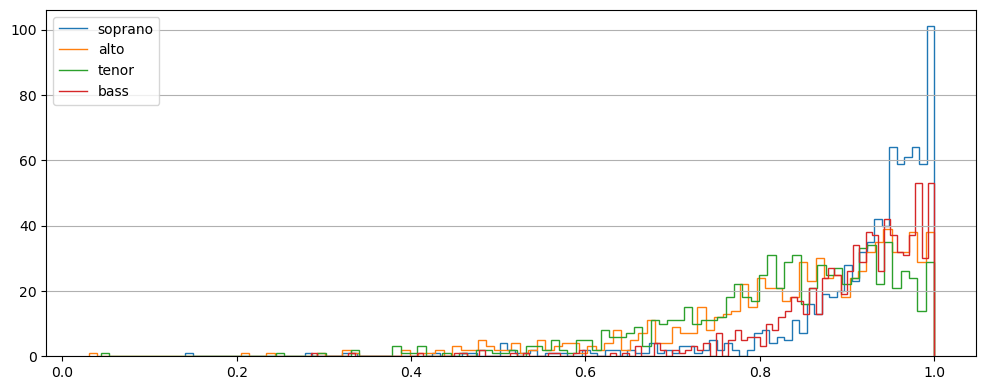

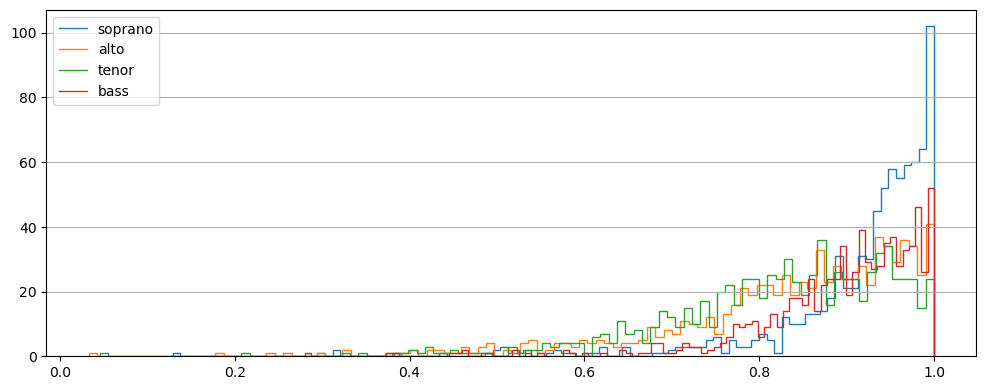

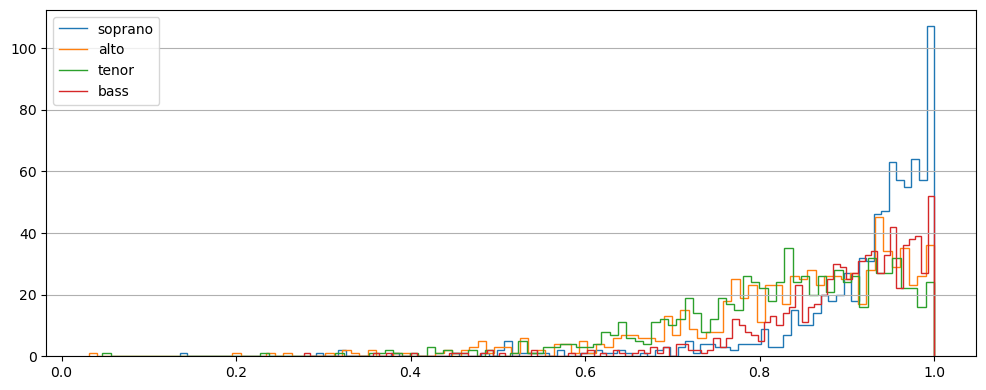

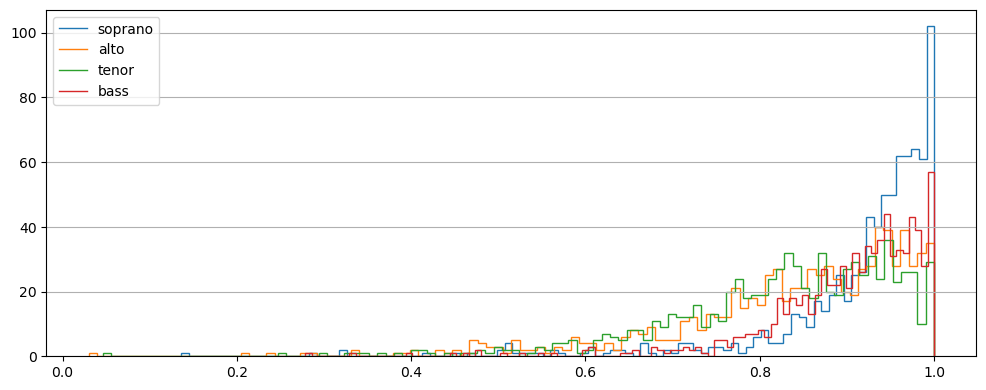

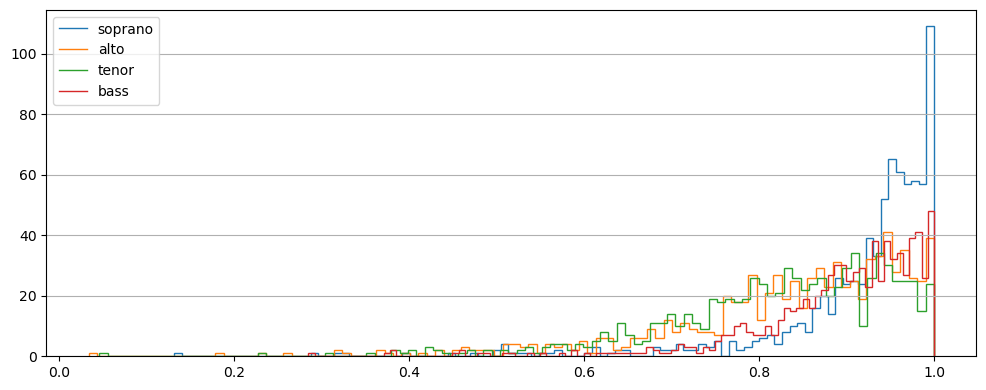

In [8]:
sscs.joint_f_histograms(f_scr1_full)
sscs.joint_f_histograms(f_scr2_full)
sscs.joint_f_histograms(f_scr3_full)
sscs.joint_f_histograms(f_scr4_full)
sscs.joint_f_histograms(f_scr5_full)

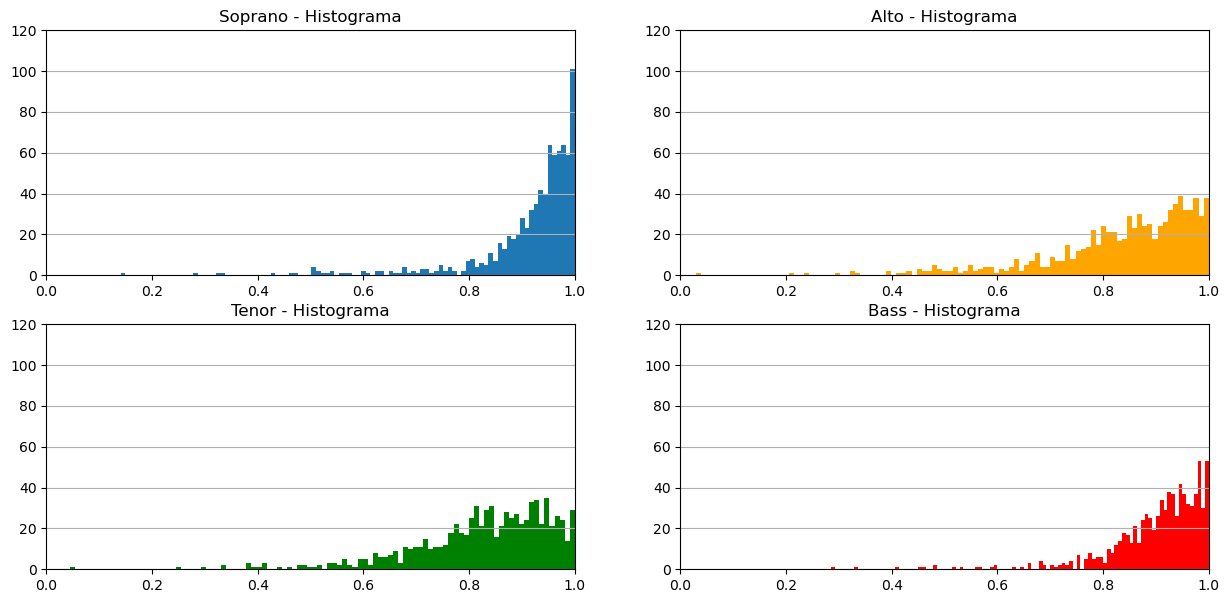

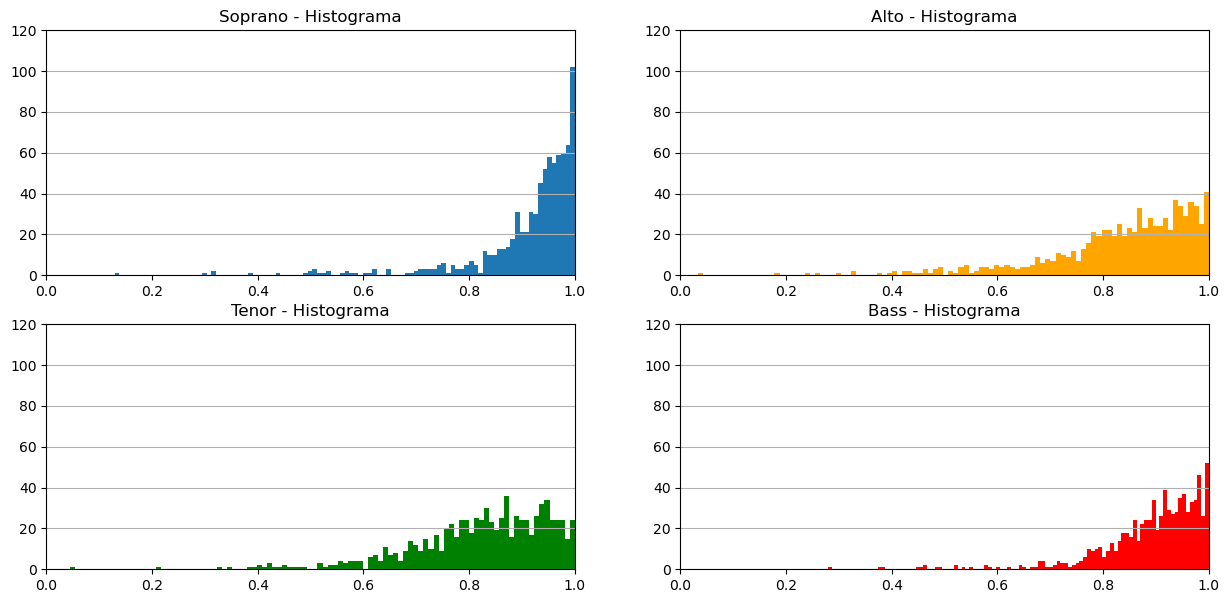

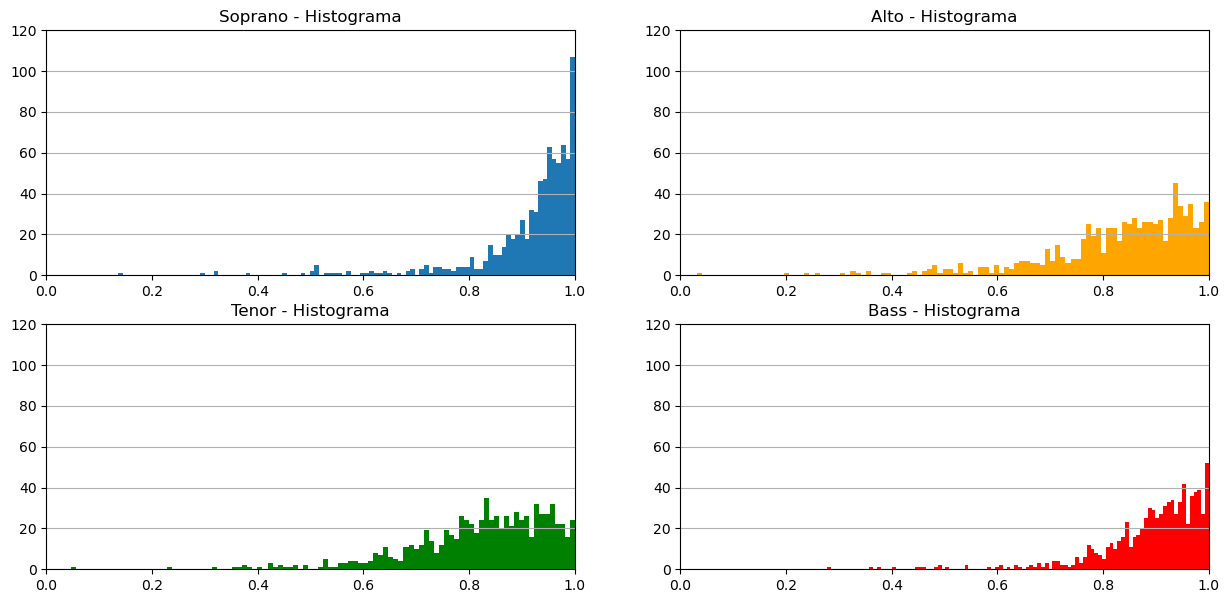

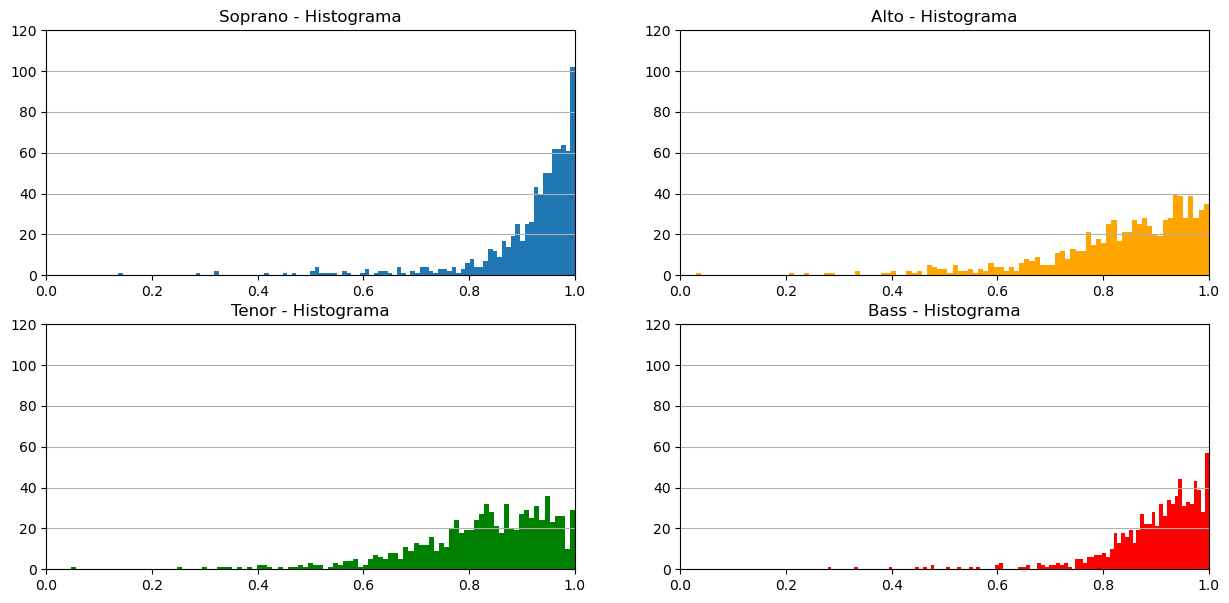

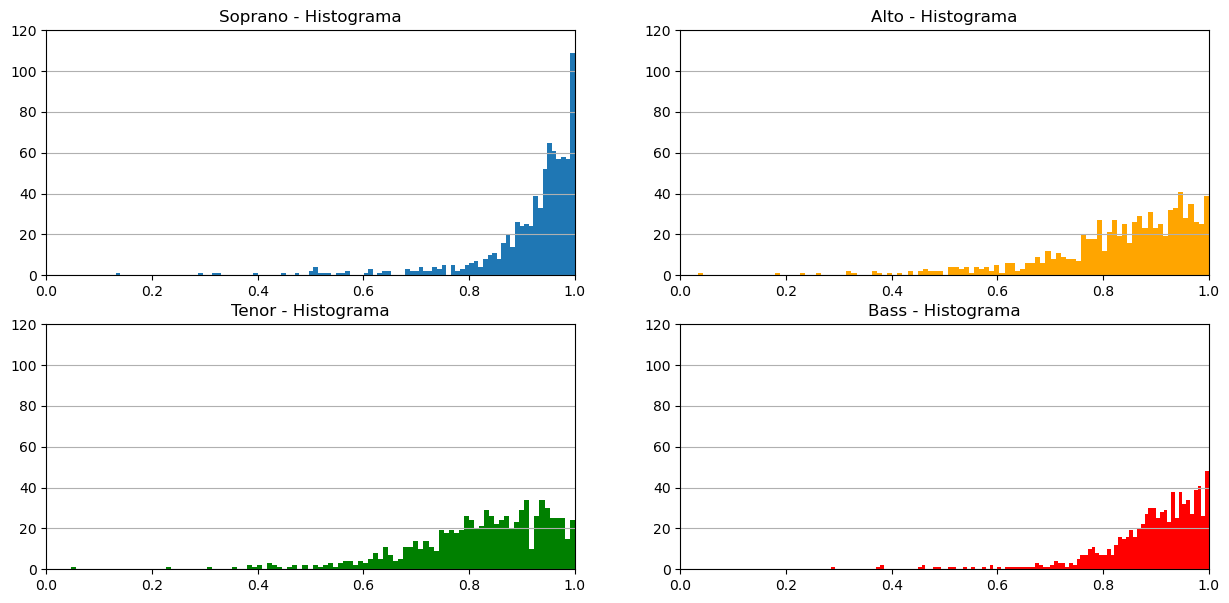

In [9]:
sscs.voice_f_histograms(f_scr1_full)
sscs.voice_f_histograms(f_scr2_full)
sscs.voice_f_histograms(f_scr3_full)
sscs.voice_f_histograms(f_scr4_full)
sscs.voice_f_histograms(f_scr5_full)

0.9499999500000026 0.8691405750000029 0.846191356250003 0.9239233493902467


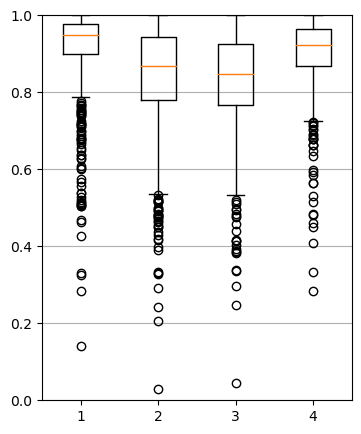

0.9475660557692333 0.8699218250000028 0.8426106270833362 0.9167968250000027


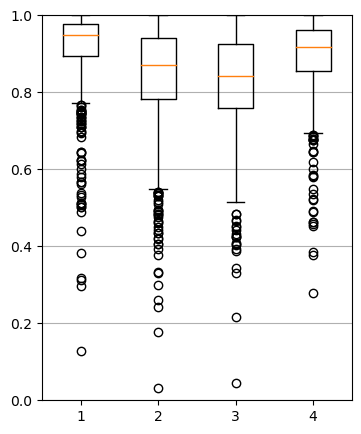

0.948390101515154 0.8632812000000029 0.8430606117647087 0.9163115030303056


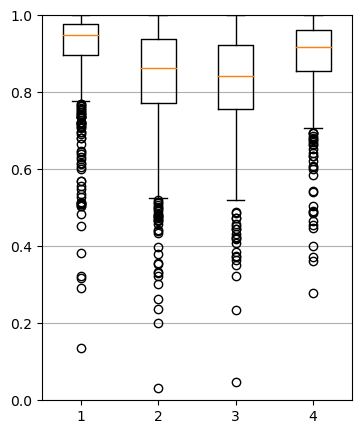

0.9478823513157921 0.8681640125000029 0.8465073029411794 0.9222300636363663


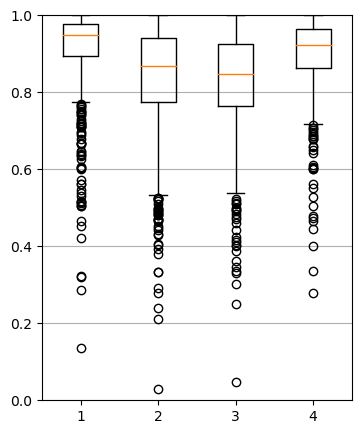

0.9491003287878814 0.8653016741379339 0.8442095088235324 0.9133300281250027


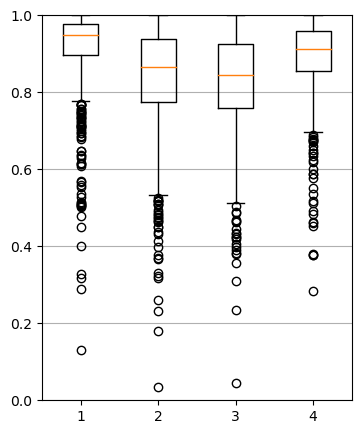

In [10]:
sscs.boxplot(f_scr1_full)
sscs.boxplot(f_scr2_full)
sscs.boxplot(f_scr3_full)
sscs.boxplot(f_scr4_full)
sscs.boxplot(f_scr5_full)

## 5 - Playground

1/1 [==============================] - 0s 27ms/step
F-Scores:
Soprano: 0.9812499500000025
Alto: 0.9374999500000026
Tenor: 0.9220702625000028
Bass: 0.9744140125000026



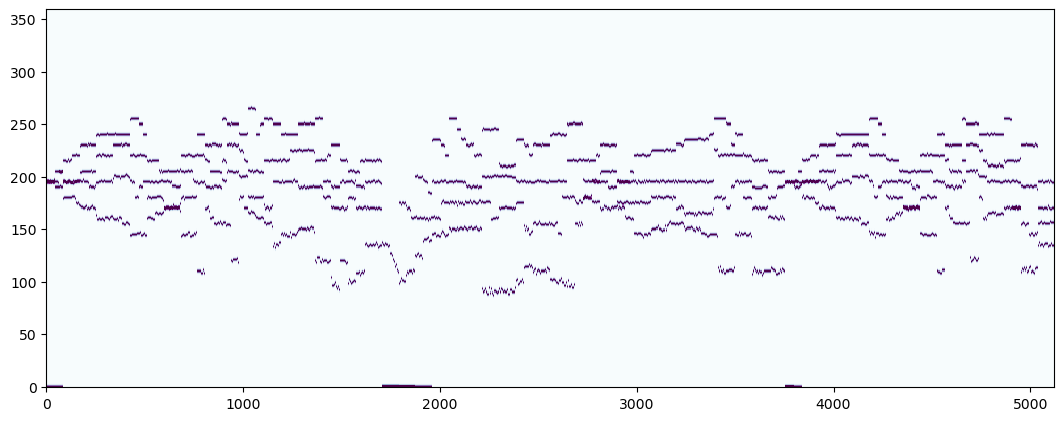

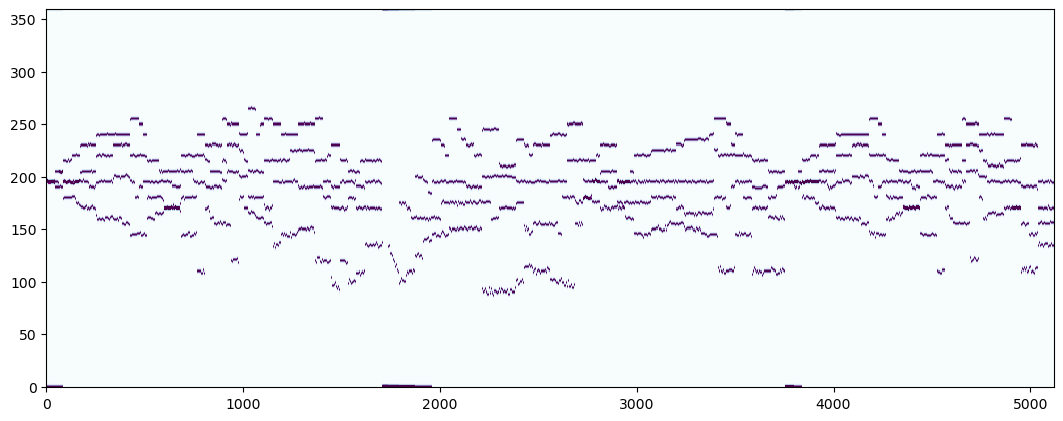

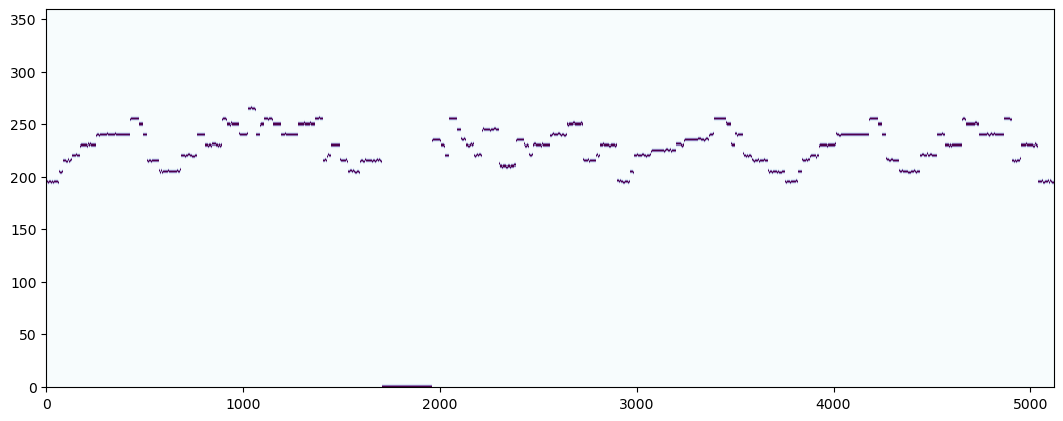

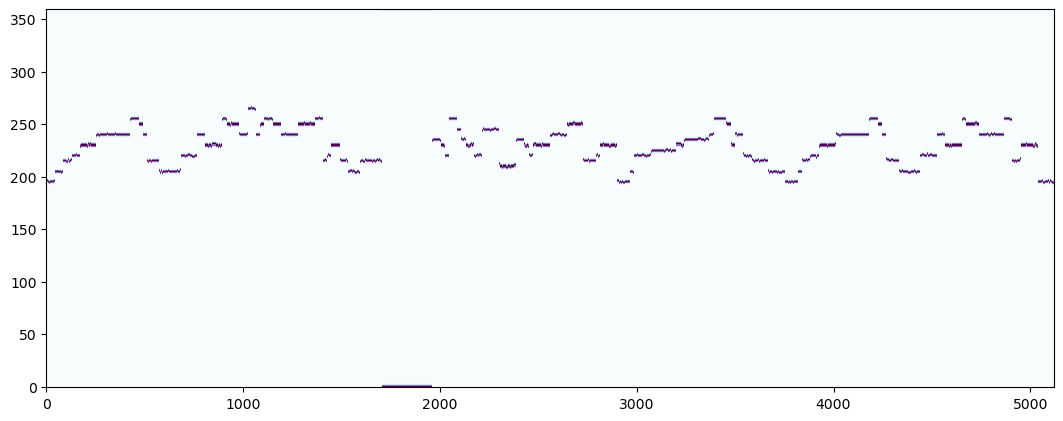

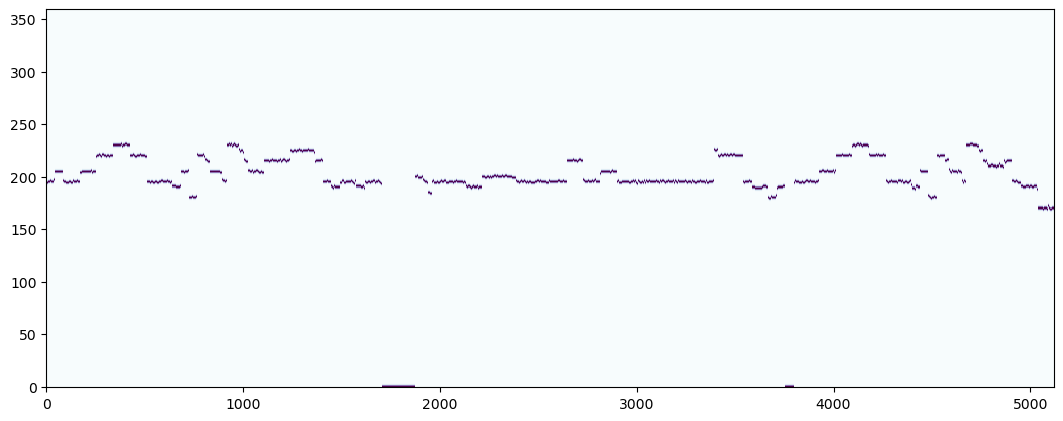

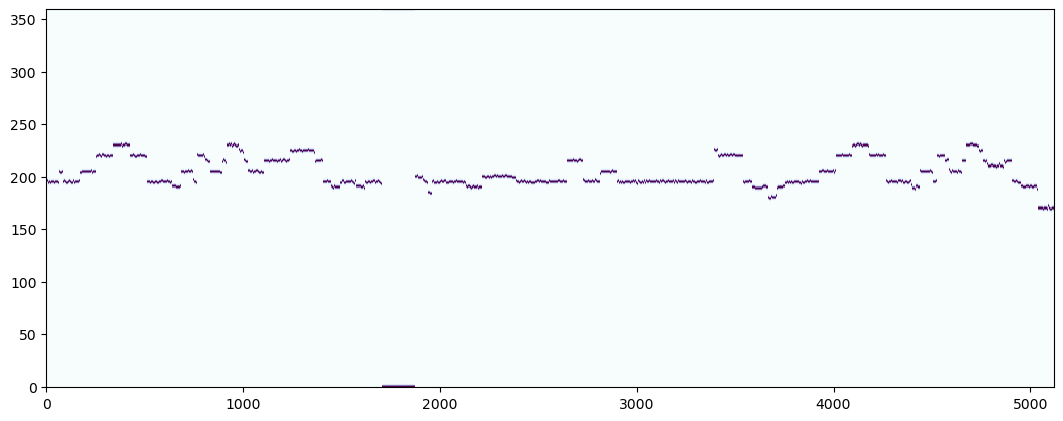

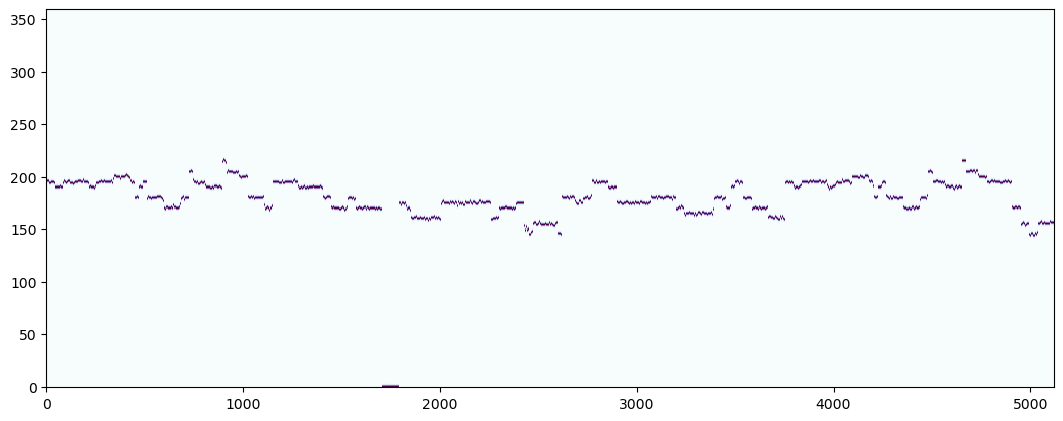

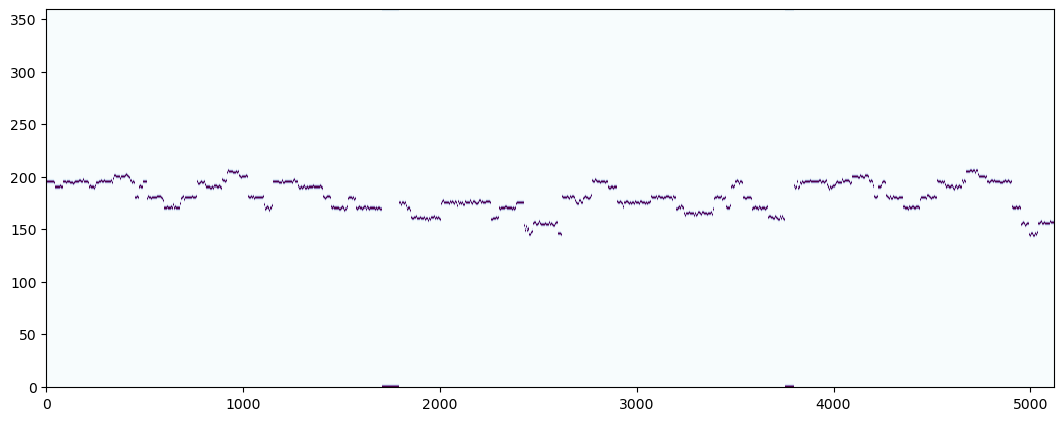

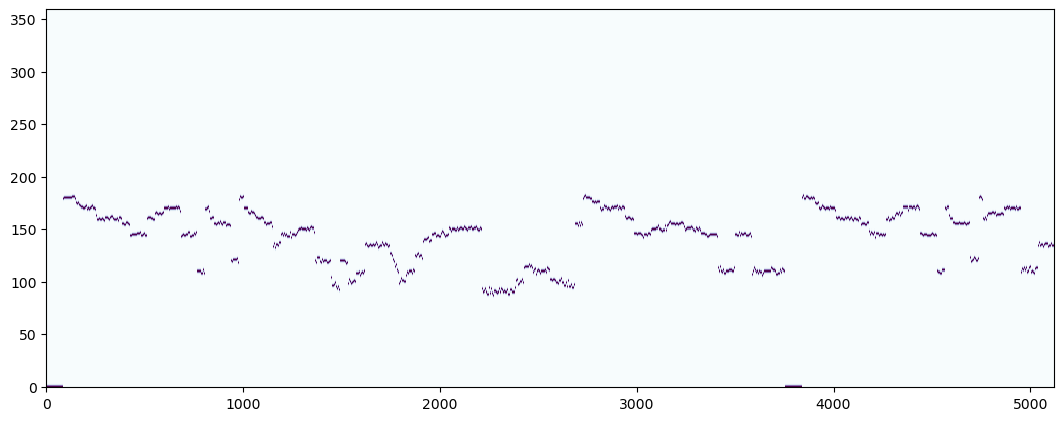

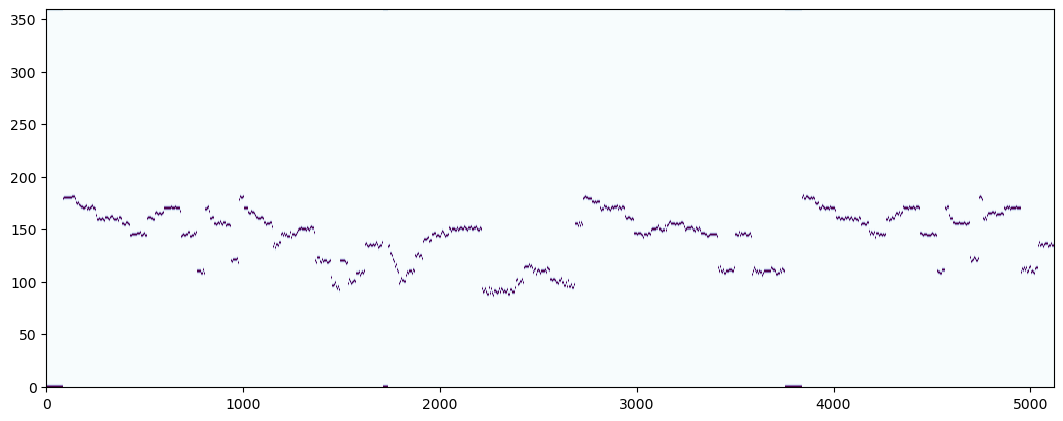

In [12]:
rand_song = sscs.pick_random_song(split='test')
mix, s, a, t, b = sscs.read_all_voice_splits(rand_song)

s_pred, a_pred, t_pred, b_pred = mask_voas_cnn.predict(mix)

mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
s = np.moveaxis(s, 0, 1).reshape(360, -1)
a = np.moveaxis(a, 0, 1).reshape(360, -1)
t = np.moveaxis(t, 0, 1).reshape(360, -1)
b = np.moveaxis(b, 0, 1).reshape(360, -1)

s_pred_postproc = sscs.prediction_postproc(s_pred).astype(np.float32)
a_pred_postproc = sscs.prediction_postproc(a_pred).astype(np.float32)
t_pred_postproc = sscs.prediction_postproc(t_pred).astype(np.float32)
b_pred_postproc = sscs.prediction_postproc(b_pred).astype(np.float32)
mix_pred_postproc = s_pred_postproc + a_pred_postproc + t_pred_postproc + b_pred_postproc
mix_pred_postproc = sscs.vectorized_downsample_limit(mix_pred_postproc)

s_fscore = sscs.f_score(s, s_pred_postproc)
a_fscore = sscs.f_score(a, a_pred_postproc)
t_fscore = sscs.f_score(t, t_pred_postproc)
b_fscore = sscs.f_score(b, b_pred_postproc)

print("F-Scores:")
print(f"Soprano: {s_fscore}")
print(f"Alto: {a_fscore}")
print(f"Tenor: {t_fscore}")
print(f"Bass: {b_fscore}")
print()

sscs.plot(mix)
sscs.plot(mix_pred_postproc)

sscs.plot(s)
sscs.plot(s_pred_postproc)

sscs.plot(a)
sscs.plot(a_pred_postproc)

sscs.plot(t)
sscs.plot(t_pred_postproc)

sscs.plot(b)
sscs.plot(b_pred_postproc)

sscs.song_to_midi(s, a, t, b, './MIDI/original.mid')
sscs.song_to_midi(s_pred_postproc, a_pred_postproc, t_pred_postproc, b_pred_postproc,
                  './MIDI/predicted.mid')